In [71]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from scipy import optimize
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [72]:
data = pd.read_csv('../data/compas-scores-two-years.csv')

In [73]:
variables = ['c_charge_degree', 'race', 'age_cat', 'score_text', 'sex', 'priors_count', 'days_b_screening_arrest', 'decile_score', 'is_recid', 'two_year_recid', 'c_jail_in', 'c_jail_out']
data = data[variables]

In [74]:
#only keep Caucasian and African-American subset
data = data.loc[(data['race'] == 'African-American') | (data['race'] == 'Caucasian')]
data = data[(data.days_b_screening_arrest <= 30) & (data.days_b_screening_arrest >= -30)]
data.drop(columns=['days_b_screening_arrest'], inplace = True)
data = data[(data.is_recid != -1) & (data.c_charge_degree != 'O') & (data.score_text != 'N/A')]
data.drop(columns=['is_recid'], inplace = True)
data['length_of_stay'] = (pd.to_datetime(data['c_jail_out'])-pd.to_datetime(data['c_jail_in'])).dt.days
data = data.drop(['c_jail_in', 'c_jail_out'], axis=1)


In [75]:
#categorical to numerical
data['race']= data['race'].replace(['African-American','Caucasian'],[0,1.0])
data['sex'] = data['sex'].replace(['Male','Female'],[0,1.0])
data['age_cat'] = data['age_cat'].replace(['25 - 45','Less than 25', 'Greater than 45'],[0,1.0,2.0])
data['c_charge_degree'] = data['c_charge_degree'].replace(['M','F'],[0,1.0])
data['score_text'] = data['score_text'].replace(['Low', 'High', 'Medium'],[0,1.0,2.0])
data = data.dropna()
data

,c_charge_degree,race,age_cat,score_text,sex,priors_count,decile_score,two_year_recid,length_of_stay
1,1.0,0.0,0.0,0.0,0.0,0,3,1,10
2,1.0,0.0,1.0,0.0,0.0,4,4,1,1
6,1.0,1.0,0.0,2.0,0.0,14,6,1,6
8,0.0,1.0,0.0,0.0,1.0,0,1,0,2
10,1.0,1.0,0.0,0.0,0.0,0,4,0,1
...,...,...,...,...,...,...,...,...,...
7207,0.0,0.0,0.0,0.0,0.0,0,2,1,0
7208,1.0,0.0,1.0,1.0,0.0,0,9,0,0
7209,1.0,0.0,1.0,2.0,0.0,0,7,0,1
7210,1.0,0.0,1.0,0.0,0.0,0,3,0,1


In [76]:
#split data
X = data.drop(columns=['two_year_recid'])
y = data.two_year_recid
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/7, random_state=0)


Baseline Model

In [77]:
base_model = LogisticRegression().fit(X_train, y_train)
accuracy_train_compas = base_model.score(X_train, y_train)
print("Train Accuracy: ", accuracy_train_compas)
accuracy_test_compas = base_model.score(X_test, y_test)
print("Test Accuracy: ", accuracy_test_compas)

Train Accuracy:  0.6761715296198055
Test Accuracy:  0.6445623342175066


In [78]:
base_y_train = base_model.predict(X_train)
base_y_test = base_model.predict(X_test)
x_sensitive_te = np.array(X_test.loc[:, 'race'])
base_y_train_2 = np.array(base_y_train)
x_sensitive_tr = np.array(X_train.loc[:, 'race'])
theta_star = base_model.coef_.flatten()
actual_train_loss = log_loss(y_train, base_model.predict_proba(X_train))

In [79]:
X_train = np.array(X_train)
X_test  = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [80]:
def optimize_function(w, x, protected_var):
    dist_bound = np.dot(w, X_train.T)
    protected_cov = (protected_var - np.mean(protected_var)) * dist_bound
    return float(abs(sum(protected_cov))) / float(X_train.shape[0])

In [81]:
def log_loss_constraint(weights, x, y, gamma):
    prod = np.dot(x, weights.reshape(X_train.shape[1],1))
    pred_probability = 1/(1+np.exp(-prod))
    predicted_classes = np.concatenate((1-pred_probability, pred_probability), axis = 1)
    loss = log_loss(y, predicted_classes)
    return (1+gamma)*actual_train_loss - loss 

In [82]:
def accuracy(w, x, y):
    shape = x.shape[1]
    pred = np.dot(x, w.reshape(x.shape[1],1))
    pred_prob = 1/(1+ np.exp(-pred))
    pred_prob[pred_prob>=0.5] = 1
    pred_prob[pred_prob<0.5] = 0
    value = np.where(pred_prob== y.reshape(pred_prob.shape))
    accuracy = value[0].shape[0]/pred_prob.shape[0]
    return accuracy, pred_prob

In [83]:
def calibration(y_pred,y_true,sensitive):
    true0 = 0
    true1 = 0
    total0 = 0
    total1 = 0
    for i in range(len(y_pred)):
        if sensitive[i]==0:
            total0 +=1
            if list(y_true)[i]==y_pred[i]:
                true0 +=1
        else:
            total1 += 1
            if list(y_true)[i]==y_pred[i]:
                true1 += 1
    true0 /= total0
    true1 /= total1
    return abs(true0 - true1)

In [84]:
def parity(y_pred,sensitive):
    true0 = 0
    true1 = 0
    total0 = 0
    total1 = 0
    for i in range(len(y_pred)):
        if sensitive[i]==0:
            total0 +=1
            if (y_pred[i]==1):
                true0 +=1
        else:
            total1 += 1
            if (y_pred[i]==1):
                true1 += 1
    true0 /= total0
    true1 /= total1
    return abs(true0-true1)

In [85]:
def EOD(y_pred,y_true,sensitive):
    true0 = 0
    true1 = 0
    total0 = 0
    total1 = 0
    for i in range(len(y_pred)):
        if(sensitive[i]==0 and y_true [i]==0):
            total0 +=1
            if (y_pred[i]==0):
                true0 +=1
        elif(sensitive[i]==1 and y_true[i]==0):
            total1 += 1
            if (y_pred[i]==0):
                true1 += 1
    true0 /= total0
    true1 /= total1
    return abs(true0-true1)

In [86]:
def p_rule_percent(sensitive, y_predicted):
    
    z_one_index = np.where(sensitive == 1)[0]  
    z_zero_index = np.where(sensitive == 0)[0] 
    
    total_protected = len(z_one_index)
    total_unprotected = len(z_zero_index)

    prediction_protected = np.where(y_predicted[z_one_index]==1)[0]
    prediction_unprotected = np.where(y_predicted[z_zero_index]==1)[0]
    
    total_protected_pred = len(prediction_protected)
    total_unprotected_pred = len(prediction_unprotected)


    protected_ratio = total_protected_pred/total_protected
    unprotected_ratio = total_unprotected_pred/total_unprotected
    
    p_percent_ratio = min(protected_ratio/unprotected_ratio, unprotected_ratio/protected_ratio)
    return p_percent_ratio,protected_ratio, unprotected_ratio 

In [87]:
def optimization(x_train, y_train, x_test, y_test, protected_attr, protected_attr_test, gamma, optimal_weights):
    cons = {'type':'ineq', 'fun': log_loss_constraint, 'args': (x_train, y_train, gamma)}

    result = optimize.minimize(optimize_function, x0=optimal_weights,args= (x_train,protected_attr),method='SLSQP',constraints=cons,options={'maxiter':10000})
    
    accuracy_train, pred_y = accuracy(result.x, x_train, y_train)
    p_rule_val, prot_perc, nonp_perc = p_rule_percent(protected_attr, pred_y)
    calib_train = calibration(pred_y, y_train.flatten(),x_sensitive_tr)
    
    accuracy_test, y_pred_test = accuracy(result.x, x_test, y_test)
    p_rule_val_test, prot_perc_test, nonp_perc_test = p_rule_percent(protected_attr_test, y_pred_test)
    calib_test = calibration(y_pred_test, y_test.flatten(),x_sensitive_te)
    parity_test = parity(y_pred_test,x_sensitive_te)
    EOD_test = EOD(y_pred_test, y_test.flatten(),x_sensitive_te)
    
    print("\nTest Accuracy for gamma ",gamma,": ",accuracy_test)
    print("P Rule percent: ", p_rule_val_test)
    print("calibration: ", calib_test)
    print("parity: ", parity_test)
    print("Equality of odds: ", EOD_test)
    
    return accuracy_train,pred_y, p_rule_val, calib_train, accuracy_test, p_rule_val_test, y_pred_test,calib_test, parity_test, EOD_test

In [88]:
#Adding Bias Factor
bias_factor_train = np.ones(X_train.shape[0]).reshape(X_train.shape[0],1)
bias_factor_test = np.ones(X_test.shape[0]).reshape(X_test.shape[0],1)
X_test =  np.concatenate((X_test, bias_factor_test), axis = 1)
X_train = np.concatenate((X_train, bias_factor_train), axis = 1)
#Creating lists to store the results
accuracy_list, p_list, cal_list_tr, cal_list_te =  [],[],[],[]
accuracy_list_test, p_test, parity_list_te, EOD_te = [],[], [], []
y_pred_tr,y_pred_te = [], []
#Creating the Weights Dataframe
weights_df = np.concatenate((base_model.coef_, base_model.intercept_.reshape(1,1)),axis=1)
weights_df = weights_df.flatten()
for g in [0.1,0.15,0.2,0.5]:   #gamma values 
    (accuracy_train, pred_y, p_rule_val, calib_train, accuracy_test, p_rule_val_test, y_pred_test, calib_test, parity_test, EOD_test) = optimization(X_train, y_train, X_test, y_test,x_sensitive_tr,x_sensitive_te,g,weights_df)
    accuracy_list.append(accuracy_train)
    y_pred_tr.append(pred_y)
    p_list.append(p_rule_val)
    accuracy_list_test.append(accuracy_test)
    y_pred_te.append(y_pred_test)
    p_test.append(p_rule_val_test)
    cal_list_tr.append(calib_train)
    cal_list_te.append(calib_test)
    parity_list_te.append(parity_test)
    EOD_te.append(EOD_test)


Test Accuracy for gamma  0.1 :  0.6180371352785146
P Rule percent:  0.5748663101604279
calibration:  0.04806687565308254
parity:  0.09968652037617554
Equality of odds:  0.06414806163245135

Test Accuracy for gamma  0.15 :  0.5848806366047745
P Rule percent:  0.9031877213695395
calibration:  0.10553814002089867
parity:  0.017136886102403354
Equality of odds:  0.043843493104532616

Test Accuracy for gamma  0.2 :  0.5769230769230769
P Rule percent:  0.6598240469208212
calibration:  0.09759665621734581
parity:  0.02424242424242424
Equality of odds:  0.027716634472844892

Test Accuracy for gamma  0.5 :  0.5663129973474801
P Rule percent:  0.24444444444444444
calibration:  0.10512016718913275
parity:  0.007105538140020899
Equality of odds:  0.0


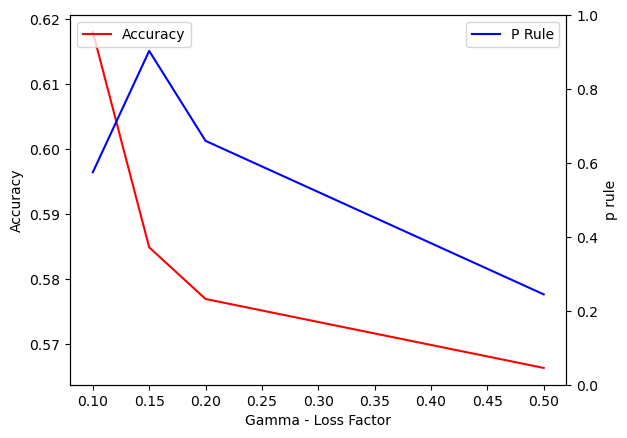

In [89]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot([0.1,0.15,0.2,0.5], accuracy_list_test, 'r-', label='Accuracy')
ax2.plot([0.1,0.15,0.2,0.5], p_test, 'b-', label='P Rule')
ax1.set_xlabel('Gamma - Loss Factor')
ax1.set_ylabel('Accuracy')
ax2.set_ylabel('p rule')
ax2.set_ylim(0, 1)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()

Text(0, 0.5, 'calibration')

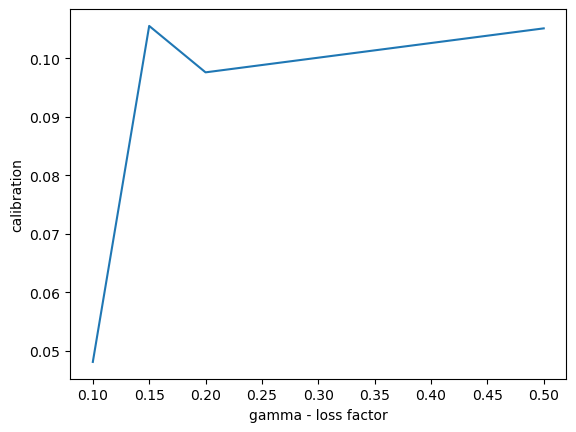

In [90]:
plt.plot([0.1,0.15,0.2,0.5], cal_list_te)
plt.xlabel('gamma - loss factor')
plt.ylabel('calibration')

Text(0, 0.5, 'parity')

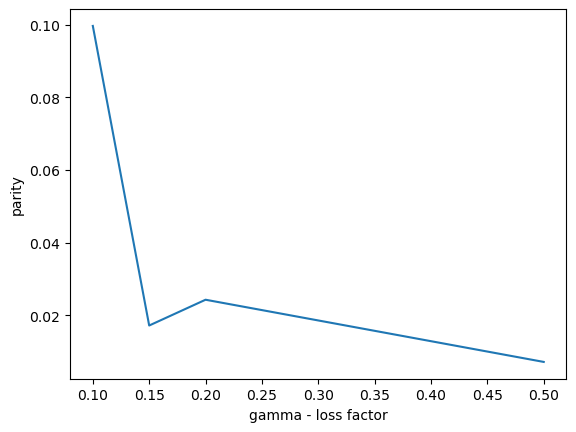

In [91]:
plt.plot([0.1,0.15,0.2,0.5], parity_list_te)
plt.xlabel('gamma - loss factor')
plt.ylabel('parity')

Text(0, 0.5, 'EOD')

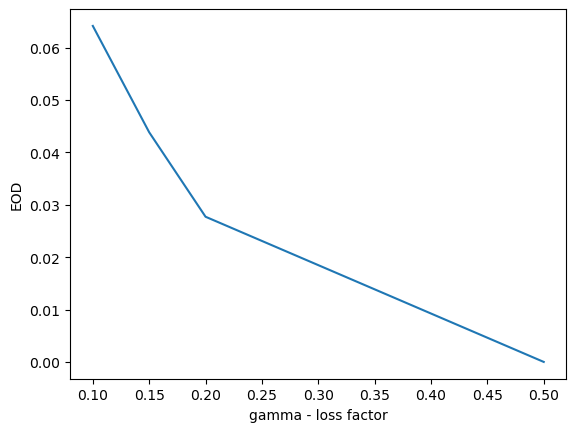

In [92]:
plt.plot([0.1,0.15,0.2,0.5], EOD_te)
plt.xlabel('gamma - loss factor')
plt.ylabel('EOD')